# Upload and unzip data

In [ ]:
from zipfile import ZipFile

file_name = "/content/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia PyCall PyPlot StatsBase" # Plots"  #BenchmarkTools
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.2 on the current Colab Runtime...
2024-06-24 13:36:02 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz [123295596/123295596] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package PyCall...
Installing Julia package PyPlot...


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 2


# Add Packages

In [2]:
using Pkg; Pkg.add(url="https://github.com/FrancescoCalvanese/FCSeqTools.jl");
using FCSeqTools, StatsBase, Statistics, LinearAlgebra, PyCall, PyPlot;
include("utils.jl");
using .utils;

     Cloning git-repo `https://github.com/FrancescoCalvanese/FCSeqTools.jl`
    Updating git-repo `https://github.com/FrancescoCalvanese/FCSeqTools.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Distances ─ v0.10.11
   Installed ExportAll ─ v0.1.2
    Updating `~/.julia/environments/v1.7/Project.toml`
  [548e5187] + FCSeqTools v0.1.0 `https://github.com/FrancescoCalvanese/FCSeqTools.jl#main`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [b4f34e82] + Distances v0.10.11
  [ad2082ca] + ExportAll v0.1.2
  [548e5187] + FCSeqTools v0.1.0 `https://github.com/FrancescoCalvanese/FCSeqTools.jl#main`
Precompiling project...
  ✓ ExportAll
  ✓ Distances
  ✓ FCSeqTools
  3 dependencies successfully precompiled in 3 seconds (41 already precompiled)


---
# **Section 1:**  Training an eaDCA Model on RNA Structures

## We will begin by training an eaDCA model on a specific RNA family, which is known to fold into a **internal loop** structure. After conducting some analysis on the internal loop structure, we will proceed to another structure called the **hairpin**.


structures.svg

## Some useful functions:

``` julia
read_fasta(file_path::String)
"""
Parameters:
file_path: The path to the FASTA file.

Returns:
data: A matrix containing the sequences represented as Potts spins.
"""
```

```julia
results = eaDCA(q::Int, lambda::Float, nchains::Int, data::Matrix{Int}, output_file::String)
"""
Train Potts model with edge activation algorithm.

Parameters:
q           : The number of nucleotides.
lambda      : The regularization parameter (use 0.1).
nchains     : The number of sequences used by the algorithm to train the model (use 7,000).
data        : The matrix containing the training data.
output_file : The name of the output file where results will be saved. (example: eaDCA_output.txt)

Returns:
score           : A vector depicting the scores acquired throughout the training phases.
likelihood_gain : A vector showcasing the likelihood gains acquired during the training phases.
sequences       : The artificial sequences generated by the model.
J               : A matrix representing the coupling within the model.
h               : A vector containing the local fields learned by the model.
contact_list    : The contact list derived from the learned graph.
site_degree     : The site degree derived from the learned graph.
edge_list       : The edge list derived from the learned graph.
"""
```

---
## **Task 1:** Train the eaDCA model on the Internal Loop RNA family.



> - Internal Loop RNA sequences: /content/data/train_sequences_1.fasta;





---
## **Task 2**: Show that the natural sequences are accurately depicted by the model's energy landscape.



```julia
sequences_energy(data::Matrix{Int}, q::Int, h::Vector{Float}, J::Matrix{Float})
"""
Parameters:
- data: A matrix of training data, where each row represents a sequence.
- q: An integer representing the number of nucleotides.
- h: A vector of floats representing the local fields learned by the model.
- J: A matrix of floats representing the coupling between elements in the model.

Output:
- energy: A vector of floats containing the energy values for each sequence in the dataset.
"""
```




In [42]:
# histogram
num_bins = 40
plt.figure(figsize=(10, 5))
plt.hist(........, label=".........", bins=num_bins, alpha=0.5, color="blue", edgecolor="black", density=true)
plt.hist(........, label=".........", bins=num_bins, alpha=0.5, color="green", edgecolor="black", density=true)
plt.title("........")
plt.xlabel("........")
plt.ylabel("........")
plt.legend()
plt.show()

LoadError: syntax: invalid identifier name "..."

# **Section 2:** Secondary structure prediction:
---
## **Task 1:** Plot the secondary structure of the Internal Loop RNA family.



```julia
read_secondary_structure(file_path::String)
"""
Read the secondary structure information from a file.

Parameters:
- file_path: Path to the file containing the secondary structure information.

Output:
- contact_matrix: Matrix where each element (i, j) contains either 1 or 0, indicating whether residues i and j form a contact or not.
"""

```

> - Secondary Strucuture Internal Loop: /content/data/structures_1.txt

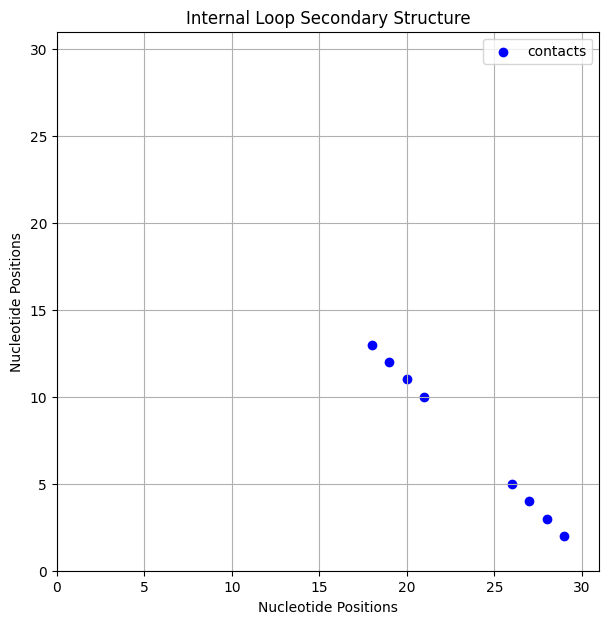

In [34]:
# read contact map from file
contact_matrix_1 = read_secondary_strucuture("/content/data/structures_1.txt")

# plot contacts
contacts = findall(x -> x .> 0, contact_matrix_1)
x = getindex.(contacts, 1)
y = getindex.(contacts, 2)
plt.figure(figsize=(7, 7))
plt.scatter(y, x, label="contacts", color="blue")
plt.xlim(0, 31)
plt.ylim(0, 31)
plt.title("Internal Loop Secondary Structure")
plt.xlabel("Nucleotide Positions")
plt.ylabel("Nucleotide Positions")
plt.grid()
plt.legend()
plt.show()

---
## **Task 2:** Given the DCA model predict the contacts of the Internal Loop RNA and compare them with the true contacts.




```julia
frobenius_norm(J::Matrix{Float}, q::Int, L::Int)
"""
Calculate the Frobenius norm of the coupling matrix.

Parameters:
- J: Coupling matrix representing pairwise interactions.
- q: Number of nucleotides.
- L: Length of the sequence.

Output:
- J: LxL matrix containing the Frobenius norm of the coupling matrix.
"""
```

```julia
plot_contact_map(predicted_contact_matrix::Matrix{Float}, true_contact_matrix::Matrix{Int}, threshold::Float)
"""
Plot the contact map based on predicted and true contact matrices.

Parameters:
- predicted_contact_matrix: LxL matrix containing predicted contact values.
- true_contact_matrix: True contact matrix.
- threshold: Threshold value for cutting off the predicted contact matrix.
"""
```




## - Adjust the threshold to enhance the clarity of the secondary structure signal.
## - Can you explain why the pairings **(6,25)** and **(9,22)** are so difficult to distinguish from the real contacts?



---
## **Task 4:** Can you localize any active site?

```julia
norm(data::Array)
"""
Compute the norm of a vector or matrix.

Parameters:
- data: Vector or matrix for which the norm is to be computed.
"""

```



In [43]:
plt.bar(......, ......)
plt.title("......")
plt.xlabel("("......")")
plt.ylabel("("......")");

LoadError: syntax: invalid identifier name "..."


# **Section 3:** Prediction on the *Deep Mutational Scan* (DMS)

## Let's delve into another RNA family: the **hairpin**.

> Within the *data* folder, you'll encounter several files: \
> - training sequences: /content/data/train_sequences_2.fasta; \
> - DMS sequences: /content/data/DMS_2.fasta;  \
> - experimental fitness: /content/data/fitness_DMS_2.txt; \


---
## **Task 1:** How can we accurately predict fitness outcomes in a DMS scenario?



```julia
read_fitness(file_path::String)
"""
Read fitness values from a .txt file.

Parameters:
- file_path: Path to the .txt file containing the fitness values.

Output:
- Vector containing the fitness values.
"""
```


```julia
plot_DMS_prediction(fitness, score_vector)
"""
Plot experimental fitness against prediction scores for each mutation.

Parameters:
- fitness: Vector containing the experimental fitness of each mutation.
- score_vector: Vector containing the prediction score for each mutation.
"""

```


# **(BONUS) Section 4:** Family assignment

### Considering the two RNA families we've examined (*hairpin* and *interior loop*), we aim to classify a generic sequence into one of these two families. How can we tackle this challenge?

---
# **Task 1:** perform a logistic regression and compute the accuracy.


> - File with sequences to assign and true label: /content/data/sequences_to_assign.fasta




```julia
read_sequences_and_labels(file_path::String)
"""
Read sequences and their corresponding labels from a file.

Parameters:
- file_path: Path to the file containing sequences and labels.

Returns:
- sequences: Vector of sequences read from the file.
- labels: Vector of labels corresponding to each sequence.
"""
```



In [39]:
sequences_to_assign, labels = read_sequences_and_labels("/content/data/sequences_to_assign.fasta");

In [40]:
@pyimport sklearn.linear_model as lm
@pyimport sklearn.metrics as metrics


LR = lm.LogisticRegression()

# create dataset containing sequences of family 1 and 2
data_1_2 = vcat(data_1, data_2)
# define the labels
labels_1_2 = ones(size(data_tot, 1))
labels_1_2[size(data_1, 1) + 1 : end] .+= 1;

# fit logistic regression
LR.fit(one_hot_encoding(data_1_2, q), labels_1_2)
LR_prediction = LR.predict(one_hot_encoding(sequences_to_assign, q))

# compute the score of the logistic regression
metrics.accuracy_score(LR_prediction, labels)

0.545

---
## **Task 2:** Determine a method to assign labels to the sequences utilizing the trained models and compute its accuracy.


---
# **Mutable sites:** Mutations tend to be more harmful in areas with exceptionally low mutability. A proxy for the mutability of a sequence is represented by the model entropy.



```julia
context_dependent_entropy(sequence::Vector, L::Int, q::Int, J::Matrix{Float}, h::Vector{Float})
"""
Compute context-dependent entropy for a given sequence.

Parameters:
- sequence: Vector representing the sequence.
- L: Length of the sequence.
- q: Number of nucleotides.
- J: Coupling matrix representing pairwise interactions.
- h: Vector of local fields.

Returns:
- entropy: Vector containing context-dependent entropy for each position in the sequence.
"""
```



```julia
context_independent_entropy(data, q)

"""
Compute context-independent entropy for given dataset.

Parameters:
- data: Input data for entropy calculation.
- q: Number of nucleotides.

Returns:
- entropy: Context-independent entropy.
"""

```

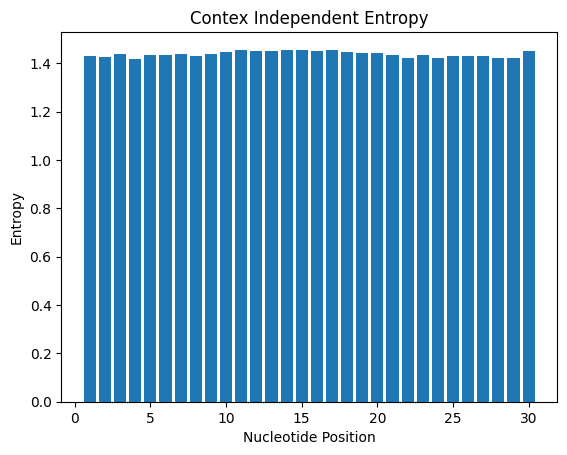

In [47]:
# compute context INDEPENDENT entropy from the data
CIE = context_independent_entropy(data_2, q)

plt.bar(1:L, CIE)
plt.title("Contex Independent Entropy")
plt.xlabel("Nucleotide Position")
plt.ylabel("Entropy");

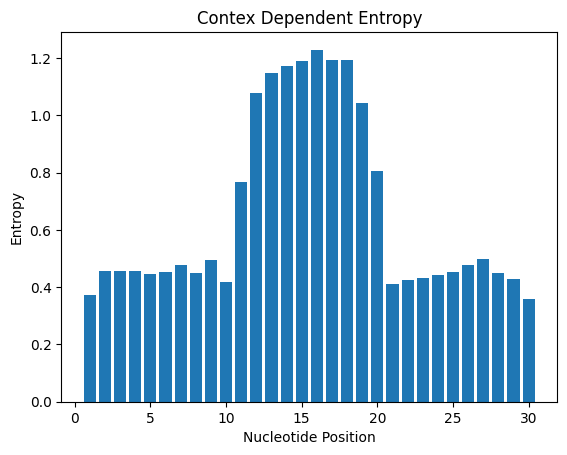

In [32]:
# compute context DEPENDENT entropy from the model
average_CDE = zeros(Float64, L)
for i in 1:size(data_2, 1)
  average_CDE  .+= context_dependent_entropy(data_2[i, :], L, q, J_2, h_2)
end

average_CDE = average_CDE ./ size(data_2, 1)
plt.bar(1:L, average_CDE)
plt.title("Contex Dependent Entropy")
plt.xlabel("Nucleotide Position")
plt.ylabel("Entropy");

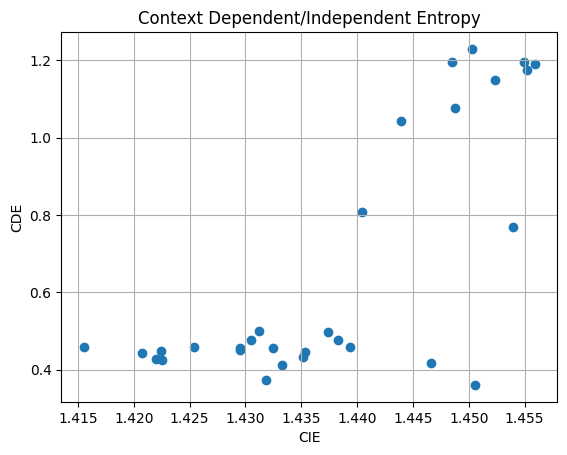

In [28]:
plt.scatter(CIE, average_CDE);
plt.title("Context Dependent/Independent Entropy")
plt.xlabel("CIE");
plt.ylabel("CDE");
plt.grid();

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />